In [1]:

import json
from writereadfile import *

#the training corpus contains 281338 unique tweets, no retweets included, collected from Ecuador in Nov2016
#plus a pool of politicians tweets with 38551 tweets
#training corpus has 319889 tweets
#tests applied with stemming and NOStemming, at the end best results with NO Stemming
#tweets saved in:
'tweets_inCorpusReady'

#the txt file to train word2vec is: tweetsNOStemmed_corpusReady_word2vec
#the model or representation of words in vec had 300 dimensions:
tweetsNOStemmed_words2vec300.bin

# Create the vector representation for the documents (tweets) in training data to start to detect clusters with k-means

In [ ]:
model300 = word2vec.load('tweetsNOStemmed_words2vec300.bin')

In [2]:
import word2vec
import numpy as np

In [17]:
##find the vector representation for the docs to then cluster them
training_corpus=load_json('tweets_inCorpusReady')
#Please, in case of requiring the training tweets contact the autor in lore_10_5@hotmail.com

In [18]:
training_corpus[0]

['Azuay',
 'miabuelasabia',
 125492611,
 793552443330166784,
 'El verdadero amor no se conoce por lo que exige, sino por lo que ofrece. \n(Jacinto Benavente)',
 'verdadero amor conoce exige sino ofrece jacinto benavente']

In [19]:
len(training_corpus)

319889

In [11]:
def docs_vectors(corpus, model): #calculate and save in a matrix the vector representation for the tweets in the corpus
    dimensions=model.vectors.shape[1]
    vocabulary=list(model.vocab)
    documents_vectors=[]
    training_tweets_new=[] #tweets only with words in vocabulary
    for doc in corpus:
        words_inDoc= doc[5].split()
        doc_vector=[model[w] for w in words_inDoc if w in vocabulary]
        if len(doc_vector)>0:
            documents_vectors.append(np.sum(doc_vector, axis=0))
            training_tweets_new.append(doc)
        #tweets with no vector representation are going to be removed from clustering founding process
        #else:
            #documents_vectors.append(np.zeros(shape=(1,dimensions)))
    documents_vectors = np.array(documents_vectors)
    return(documents_vectors, training_tweets_new)

In [62]:
docs_representation=docs_vectors(training_corpus, model300)

# Apply k++ to find the centroids in a smart way

In [67]:
from sklearn.metrics import pairwise_distances
import sys
import matplotlib.pyplot as plt

In [73]:
from scipy import spatial

In [12]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='cosine') #metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids,axis=1)
    
    return cluster_assignment

In [13]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        #centroid = centroid.A1  I don't have a numpy.matrix
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [14]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        cluster_assignment = assign_clusters(data, centroids)
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [15]:
def smart_initialize(docs_vectors, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, docs_vectors.shape[1])) #structure inicialized where to save centroids found
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(docs_vectors.shape[0])
    #print(idx)
    centroids[0] = docs_vectors[idx,:] ##docs_vectors[idx,:].toarray() if docs_vectors[idx,:] were a sparce matrix
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(docs_vectors, centroids[0:1], metric='cosine').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(docs_vectors.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = docs_vectors[idx,:] #.toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(docs_vectors, centroids[0:i+1], metric='cosine')**2,axis=1)
    
    return centroids

In [16]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i.
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='cosine')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [17]:
def plot_heterogeneity(heterogeneity, seeds, k):
    plt.figure(figsize=(7,4))
    plt.plot(seeds, heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    #plt.tight_layout()
    plt.show()

In [18]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter=maxiter,
                                           record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

In [19]:
##

def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 10})
    plt.show()


In [21]:
def visualize_document_clusters(training_corpus, docs_representation, centroids, cluster_assignment, k, model, display_content=True):
    '''training_corpus: original data, the tweet is in tweet[4]
       docs_representation: data matrix, array format
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')
    vocabulary=list(model.vocab)
    #distances_words = pairwise_distances(model.vectors, centroids, metric='cosine').flatten()
    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words in model word2vec that are nearest to the centroid vec
        #idx = centroids[c].argsort()[::-1]
        distances_words = pairwise_distances(model.vectors, centroids[c].reshape(1, -1), metric='cosine').flatten()
        idx = distances_words.argsort()[:5] ## the 5 first items index which distance is smaller
        near_words=[vocabulary[i] for i in idx]
        dist_nearWords=[distances_words[i] for i in idx]
        print(near_words)
        print(dist_nearWords)
        print('\n')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(docs_representation, centroids[c].reshape(1, -1), metric='cosine').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration if the data point was not assigned to c put and 'inf' insteaad of the distance value calculated
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = training_corpus[nearest_neighbors[i]][4]
                print(text)
                print(distances[nearest_neighbors[i]])
        print('==========================================================')

# Re-make experiments with cosine metric as pairwise distance

in the methods that contain pairwise 'euclidean' i changed for 'cosine'

In [8]:
import json
from writereadfile import *
import word2vec
import numpy as np
from sklearn.metrics import pairwise_distances
import sys
import matplotlib.pyplot as plt
import time

In [9]:
#model100 = word2vec.load('tweetsNOStemmed_words2vec100.bin')
model300 = word2vec.load('tweetsNOStemmed_words2vec300.bin')
#model500 = word2vec.load('tweetsNOStemmed_words2vec500.bin')

In [23]:
training_corpus=load_json('tweets_inCorpusReady')

In [24]:
#docs_representation=docs_vectors(training_corpus, model100)
docs_representation300,training_tweets_new300 = docs_vectors(training_corpus, model300)
#docs_representation500=docs_vectors(training_corpus, model500)

seed=000000, heterogeneity=13418.63674
seed=020000, heterogeneity=13420.86611
seed=040000, heterogeneity=13420.84547
seed=060000, heterogeneity=13418.63674
seed=080000, heterogeneity=13420.86788
seed=000000, heterogeneity=10734.37520
seed=020000, heterogeneity=10730.32532
seed=040000, heterogeneity=10882.51270
seed=060000, heterogeneity=10852.69409
seed=080000, heterogeneity=11147.28195
seed=000000, heterogeneity=9890.11181
seed=020000, heterogeneity=9997.20992
seed=040000, heterogeneity=9959.95534
seed=060000, heterogeneity=10260.61658
seed=080000, heterogeneity=10117.25715
seed=000000, heterogeneity=8829.65410
seed=020000, heterogeneity=8792.94090
seed=040000, heterogeneity=8850.02012
seed=060000, heterogeneity=9059.26924
seed=080000, heterogeneity=8809.87698
seed=000000, heterogeneity=7941.17121
seed=020000, heterogeneity=7943.94501
seed=040000, heterogeneity=7943.27815
seed=060000, heterogeneity=7916.68070
seed=080000, heterogeneity=7944.11005
seed=000000, heterogeneity=5985.98224


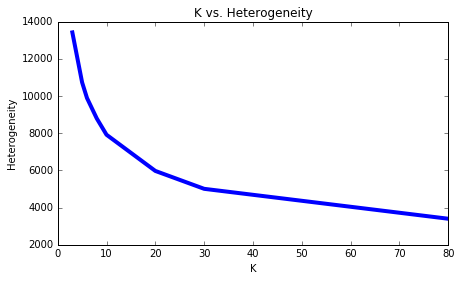

16214.266585826874


In [33]:
#### for model300

start = time.time() 
centroids300 = {}
cluster_assignment300 = {}
heterogeneity_values300 = []
k_list300 = [3, 5, 6, 8, 10, 20, 30, 80]
seed_list = [0, 20000, 40000, 60000, 80000]

for k in k_list300:
    #heterogeneity = []
    centroids300[k], cluster_assignment300[k] = kmeans_multiple_runs(docs_representation300, k, maxiter=400,
                                                               num_runs=len(seed_list),
                                                               seed_list=seed_list,
                                                               verbose=True)
    score = compute_heterogeneity(docs_representation300, k, centroids300[k], cluster_assignment300[k])
    heterogeneity_values300.append(score)

plot_k_vs_heterogeneity(k_list300, heterogeneity_values300)

end = time.time()
print(end-start)

In [36]:
heterogeneity_values300

[13418.636737352976,
 10730.325320718275,
 9890.1118136937421,
 8792.9408956265179,
 7916.6806952476363,
 5970.9670092855495,
 5009.2623597635384,
 3400.9549325330972]

In [34]:
for key in k_list300:
    centroids300[key]=centroids300[key].tolist()
    cluster_assignment300[key]=cluster_assignment300[key].tolist()
    #print(centroids300[key].tolist())

In [35]:
data300={'centroids':centroids300,'cluster_assignment':cluster_assignment300,'heterogeneity':heterogeneity_values300}
save_json('model300/data300',data300)

In [42]:
for key in k_list300:
    centroids300[key]=np.array(centroids300[key])
    cluster_assignment300[key]=np.array(cluster_assignment300[key])
    #print(centroids300[key].tolist())

In [122]:
visualize_document_clusters(training_tweets_new300, docs_representation300, centroids300[3], cluster_assignment300[3], 3, model300)

Cluster 0    
['juventudes', 'participativo', 'facilitar', 'politi', 'debaten']
[0.018994027265179181, 0.021033405502888569, 0.027350629509436897, 0.028355173239587139, 0.028980794628779005]


¡La revolución avanza! como nos comprometimos en mi enlace, CNT entregó las líneas de telefonía inalámbrica en Taisha http://t.co/LXRAZ5Qnzj
0.0127715733045
.@cesarmc0510: continuamos impulsando también el "Sello Inclusivo progresivo" con el compromiso de las empresas pri… https://t.co/GemIfleQh0
0.0128577012379
1/2 IMPORTANTE: Desarticulada violenta organización delictiva de robo y microtráfico que operaba en Guayaquil, dist… https://t.co/DtzvXLaFdC
0.0130911167931
Hoy presentamos los "Comités Familiares de CREO". Será un ejercito de 40.000 voluntarios preparados para cuidar nue… https://t.co/FZPIe48UC9
0.0135651661106
EN REUNION REALIZADA EN ROMA EL IESS Y ECUATORIANOS RESIDENTE EN ITALIA SE SINTONIZAN PARA IMPULSAR IMPORTANTES... http://t.co/5qFYCew33J
0.0159822790198
@dfeleon2 @JackitaCeli @j

In [123]:
visualize_document_clusters(training_tweets_new300, docs_representation300, centroids300[5], cluster_assignment300[5], 5, model300)

Cluster 0    
['metele', 'interpretara', 'nishikori', 'maite', 'howard']
[0.01766192305196046, 0.01769847684977055, 0.019957642288341293, 0.022265080068818, 0.022303525788950673]


American Alpha &gt; Enzo y Cass por mucho. #RAW
0.0150576107288
¿Paul Walker regresará para Rápidos y Furiosos 8? - https://t.co/W8SuWhRx3c |https://t.co/MKjVm3RQMG
0.0154535936587
Agenda "DJ TOTO"
Separa tu fecha desde ya  !!!

📱0983184284 -0990190666

"DJ TOTO MARCA DE LA… https://t.co/uB5wCtcjgZ
0.0175863944993
Paulina Rubio metió la pata en una entrega de premios / Telemundo.
https://t.co/afTFy0lIOa https://t.co/xLoWx0r0Vn
0.0180093638215
Con Neymar Jr.  y Nicky Jam : Revisa el segundo adelanto de la explosiva "xXx: Reactivado" https://t.co/zHaxwKmuLb https://t.co/4JmbUnP9Yy
0.018928902122
Acabé el 1º en el torneo de bronce en Quiz Run. Mi usuario es eli9945 https://t.co/mui9uSLhJt https://t.co/YV28f4jGjK
0.019621322805
Say say say 🎶🎵🎺🎸🎷 cuando Michael era Afroamericano 😊 @ Vinces https://t.co/LhWyrhSEkd

In [124]:
visualize_document_clusters(training_tweets_new300, docs_representation300, centroids300[6], cluster_assignment300[6], 6, model300)

Cluster 0    
['#deguayaquilalpais', 'marchas', '#ferialasso', 'protagonismo', 'innegable']
[0.018423398456763551, 0.029253049701326805, 0.02960023235926712, 0.031546014729938787, 0.032323854272968688]


Nosotros no compramos conceptos derrotistas, sino no participáramos. Estamos convencidos que llegaremos a la Presidencia de la República.
0.0128491495164
Vivimos en un momento político en el q nos han clasifica por justos e injustos. La #unidad plantea posibilidad d devolver autonomia a la AN
0.0152826716647
Me considero un demócrata radical, y para nosotros no es posible el centralismo porque anula los territorios. @notihoyecuador
0.0153231531736
Cdo en #Chile la élite política llama a respetar institucionalidad vigente y espíritu republicano, LE ESTA DICIENDO APOYE MODELO DE PINOCHET
0.0154616672145
Militancia y reciente trabajo de Chávez la justifica aún sea débil en #Babahoyo, pero como justifican en AP… https://t.co/nJgz767ghD
0.0162709892164
Y siguiendo libreto d EEUU la oposició

In [125]:
visualize_document_clusters(training_tweets_new300, docs_representation300, centroids300[8], cluster_assignment300[8], 8, model300)

Cluster 0    
['instrumental', 'uhc', 'squad', 'woman', 'movie']
[0.01796850645664172, 0.021148244923525072, 0.024769096572850313, 0.025470536054016946, 0.025499832505280207]


Me ha gustado un vídeo de @YouTube de @willyrexyt (https://t.co/fXdm3yDOVb - TOM CLANCY'S RAINBOW SIX SIEGE | UNA ENTRADA ÉPICA!).
0.0101855536956
Me gustó un video de @YouTube https://t.co/ElPFGcMDKn BTS (방탄소년단) - Save Me - (Acoustic Guitar English Version)
0.0102959962312
Me gustó un video de @YouTube de @xdarksoul1988 https://t.co/wgem8sSMtB World of Warcraft | CAZADOR PUNTERÍA PvP NIVEL 110 - PALIZA
0.0107424553723
Me ha gustado un vídeo de @YouTube de @willyrexyt (https://t.co/fR9xpZf1gd - PARKOUR SOBRE LAVA!! CARRERA ÉPICA | Minecraft Race Map
0.0120976298251
Me gustó un video de @YouTube de @eugeniekitchen https://t.co/K1nLnoDFS1 "Eugenie Cake" Rainbow Heart Surprise Mille Crepe Cake DIY
0.0126429210818
Me gustó un video de @YouTube de @toyskids7 https://t.co/wFCxMRVNc9 Finger Family Song Collection! Mick

In [126]:
visualize_document_clusters(training_tweets_new300, docs_representation300, centroids300[10], cluster_assignment300[10], 10, model300)

Cluster 0    
['tercero', '#aficion', 'cuartos', '3-2', 'rivales']
[0.020694034030048103, 0.022866656933114515, 0.02977907984773509, 0.033795136128803804, 0.034103338044916831]


#AFICIÓN Mina hizo explotar el Capwell y @CSEmelec se acerca al @BarcelonaSCweb #Orovisión #MásparaVer… https://t.co/xb6EU6xrZq
0.0129851215216
@mariocanessa lo bueno de Maximiliano Barreiro es q es un goleador forjado en la costa,los q han venido de la altura fracasaron en Barcelona
0.0149341599366
@brojotango @SabiasQueEMELEC cuando lleguen y jueguen y mas ganen una final de Copa Libertadores eso es una discusión entre  LDU IDV BSC
0.0151212565119
10' Se detiene el partido, Esteban Dreer se está cambiando de medias.

#DCuenca 0-1 #Emelec
0.0175297909943
@AllissonCantos @LDUPoficial @MantaFutbolClub ademas no es un clasico, es un partido mas.!! El clasico es con su vecino de patio @DelfinSC
0.0181298282997
Con toda la pica por la eliminación en Eurocopa se viene el Italia vs Alemania partido que nunca será am

# Create 22 clusters of tweets (not words) for the model of 300 dim

In [6]:
#data300={'centroids':centroids300,'cluster_assignment':cluster_assignment300,'heterogeneity':heterogeneity_values300}
data300=load_json('model300/data300')
centroids300=data300['centroids']
cluster_assignment300=data300['cluster_assignment']

In [7]:
centroids300.keys()

dict_keys(['3', '5', '6', '8', '10', '20', '30', '80'])

In [25]:
seed_list = [0, 20000, 40000, 60000, 80000]
centroids300['22'], cluster_assignment300['22'] = kmeans_multiple_runs(docs_representation300, 22, maxiter=400,
                                                               num_runs=len(seed_list),
                                                               seed_list=seed_list,
                                                               verbose=True)

seed=000000, heterogeneity=5703.72039
seed=020000, heterogeneity=5785.71114
seed=040000, heterogeneity=5751.12817
seed=060000, heterogeneity=5798.14607
seed=080000, heterogeneity=5788.22650


In [26]:
visualize_document_clusters(training_tweets_new300, docs_representation300, centroids300['22'], cluster_assignment300['22'], 22, model300)

Cluster 0    
['fmi', 'liberal', '#obama', 'rousseff', 'insiste']
[0.026497198259654908, 0.027050714043726831, 0.029351008820096447, 0.032607762746491131, 0.033498945615219156]


¿Reelección indefinida en Alemania? ¿Dónde está la #OpoTrucha que no se pronuncia sobre esta "dictadura"?… https://t.co/62h3gnodqq
0.0156509229226
Presidente brasileño promete veto a amnistía para la corrupción. ▶ https://t.co/7CoGuuj31H https://t.co/vElQbQA4tf
0.0183472262116
#Colombia: Santos confirma que no tiene tumor o metástasis y puede seguir sus funciones &gt;&gt; https://t.co/hynS62jnpF https://t.co/zP834e6Efs
0.0185778485686
Discurso del correismo
nos remite al discurso dictador Rodriguez Lara en 1972
con 1er barril crudo
https://t.co/Qk4JvQo4cP
#CorreazoAlYasuni
0.0197490042672
May insiste en sus planes para el #brexit pese a advertencias de la oposición británica https://t.co/YGO70i4nmk https://t.co/JbSOxY4yTM
0.021392065907
Recuerden q a raiz d esa sentencia se hizo pública carta d Secretario Jurí

In [28]:
centroids300['22']=centroids300['22'].tolist()
cluster_assignment300['22']=cluster_assignment300['22'].tolist()
data300={'centroids':centroids300,'cluster_assignment':cluster_assignment300}
save_json('model300/data300',data300)

In [27]:
centroids300.keys()

dict_keys(['3', '5', '6', '8', '10', '20', '30', '80', '22'])